## 在规划的时候，生成两个地头，耕作的方式变为“往复式”

In [1]:
import geopandas as gpd
import numpy as np
from shapely import LineString, Polygon, Point
import shapely
from shapely import ops
import matplotlib.pyplot as plt
from CPP_Planner import CPP_Algorithms, CPP_Planner_Kit, CPP_Planner_TurningRail_Maker
from shapely import affinity
from skimage.measure import approximate_polygon
import math
import warnings

warnings.filterwarnings('ignore')
all_land = gpd.read_file('test_Load_Shp/shp_file/村1地_全区.shp')
# 这里要控制精度
all_land.geometry = all_land.geometry.apply(shapely.set_precision, grid_size=0.05)
# 对当前 all_land 添加一个 mean_slope 字段 [3.37, 7.38, 6.07, 3.94, 6.53, 7.46, 7.62]
all_land['mean_slope'] = [3.37, 7.38, 6.07, 3.94, 6.53, 7.46, 7.62]

all_land

,NAME,LAYER,周长,闭合面积,geometry,mean_slope
0,地2,Unknown Area Type,315.38 m,0.001833 sq km,"POLYGON ((440417.600 4397401.450, 440401.850 4...",3.37
1,地3,Unknown Area Type,182.65 m,0.001528 sq km,"POLYGON ((440478.950 4397335.400, 440484.500 4...",7.38
2,地4,Unknown Area Type,247.41 m,0.00125 sq km,"POLYGON ((440472.250 4397608.050, 440469.000 4...",6.07
3,地5,Unknown Area Type,143.98 m,0.000743 sq km,"POLYGON ((440450.050 4397795.250, 440451.850 4...",3.94
4,地6,Unknown Area Type,120.25 m,0.000631 sq km,"POLYGON ((440352.800 4397768.750, 440351.250 4...",6.53
5,地7,Unknown Area Type,147.18 m,0.001222 sq km,"POLYGON ((440315.750 4397785.800, 440309.100 4...",7.46
6,地1_区,Unknown Area Type,442.09 m,0.004246 sq km,"POLYGON ((440410.850 4397414.750, 440398.850 4...",7.62


split_polygon_by_largest_area： 开始进行田块分割，当前误差范围 tolerance = 0.05
Num of convex_hull:  12
Num of Polygon lines:  20
Not on Convex:  11
Num of convex_hull:  7
Num of Polygon lines:  9
Not on Convex:  4


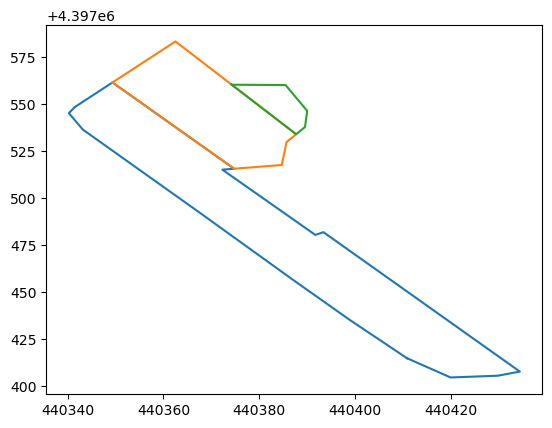

In [2]:
single_land = CPP_Planner_Kit.get_single_shp(all_land, 6)
# single_land.plot()
split_polygon = CPP_Planner_Kit.split_polygon_by_largest_area(single_land.geometry.iloc[0], tolerance=0.05)
_, ax = plt.subplots()
for polygon in split_polygon:
    ax.plot(*polygon.exterior.xy)

当前田块角度： 118.93499989663447


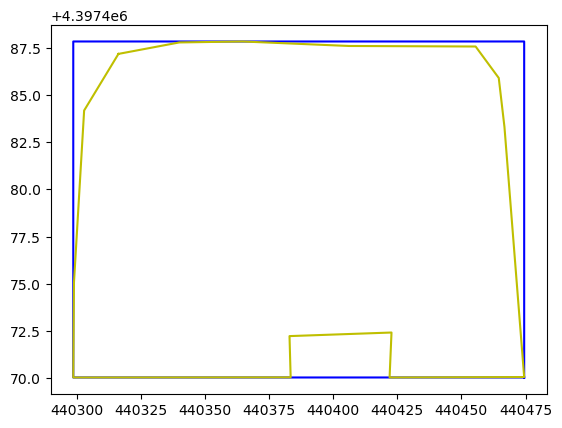

In [3]:
single_polygon = split_polygon[0]
single_polygon_angle = CPP_Planner_Kit.get_land_MABR_angle(single_polygon)
single_polygon = affinity.rotate(single_polygon, -single_polygon_angle, origin='centroid')
mabr = single_polygon.minimum_rotated_rectangle
_, ax = plt.subplots()
ax.plot(*mabr.exterior.xy, color='b')
ax.plot(*single_polygon.exterior.xy, color='y')

#### 开始尝试 一块耕地两个地头的路径规划

In [4]:
# 输入的基础参数
swath_width = 1.45
vehicle_length = 6.3
vehicle_width = 1.9
turning_radius = 4.5
all_land_slope = [3.37, 7.38, 6.07, 3.94, 6.53, 7.46, 7.62]
headland_width, theta = CPP_Planner_Kit.calc_headland_width(turning_radius, swath_width, vehicle_length, vehicle_width,
                                                            buffer=0.3, show_info=True)

Theta:  0.6682897949014295
r2:  6.294839156007086
Theta2:  0.5240721827749459
w2: 5.849442958825377
Buffer:  0.3
最终地头宽度:  9.299442958825377


<Axes: >

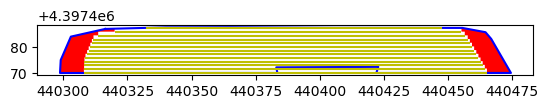

In [5]:
corrected_swath_width = CPP_Planner_Kit.get_corrected_swath_width(swath_width, all_land_slope[6])

path, two_headland = CPP_Algorithms.scanline_algorithm_single_with_headland(
    gpd.GeoDataFrame(geometry=[single_polygon], crs=all_land.crs), corrected_swath_width, along_long_edge=False,
    headland='both',
    head_land_width=headland_width
)
_, ax = plt.subplots()
ax.plot(*single_polygon.exterior.xy, 'b')
path.plot(ax=ax, color='y')
two_headland.plot(ax=ax, color='r')

In [6]:
multi_poly = two_headland.geometry[0]
print(type(multi_poly))
for poly in multi_poly.geoms:
    print(type(poly))
    print(poly.area)

<class 'shapely.geometry.multipolygon.MultiPolygon'>
<class 'shapely.geometry.polygon.Polygon'>
146.1126324116621
<class 'shapely.geometry.polygon.Polygon'>
0.028933424631113487
<class 'shapely.geometry.polygon.Polygon'>
146.91078234172423


#### 测试：通过往复式、转圈的方式访问各个耕作路径
* 首先将问题抽象：
    *   分出转向区域的地头
    *   考虑每一条耕作路径的进出方向安排

In [7]:
len(path.geometry)

13

In [8]:
CPP_Planner_TurningRail_Maker.calc_min_swath_jump(4.5, 1.45)

7.0

In [9]:
CPP_Planner_TurningRail_Maker.calc_flat_turn_headland_width(4.5, 6.3, 1.9)

9

In [10]:
a = (turning_radius + vehicle_width / 2) ** 2
print(a)
b = (vehicle_length / 2) ** 2
print(b)

29.7025
9.9225


#### 计算当前田块内垄的耕作方式

In [11]:
def test_gen_path_tillage_type(t_path: gpd.GeoDataFrame, t_turning_radius: float, t_vehicle_length: float,
                               t_vehicle_width: float, t_swath_width: float):
    # 由于田块内的耕作垄是等距离的，直接抽象成点集合（横向从左到右，垄是竖立的）
    # 有三种情况：0 使用鱼尾转向，1 向右间隔 最近可达垄+1垄 耕作，2 向左最近可达垄耕作，反向：3 4
    n = len(t_path)
    # n = 16
    swaths = [0 for i in range(n)]
    min_jump_swaths = int(CPP_Planner_TurningRail_Maker.calc_min_swath_jump(t_turning_radius, t_swath_width))
    # 使用 “平滑转向” 下，最大一次可以完整耕作的垄数（由于是 0 开始，减一）
    max_length = int((min_jump_swaths + 1) * 2 - 1)
    iteration = int(n // max_length)
    print(iteration)
    if n % max_length != 0:
        iteration += 1
    direction = False  # 当为 true 表示 向右（正向），false 向左（反向）
    is_up = False  # 当作方向， true 表示上方 右，下方 左，false 表示，下方 右，上方左  为了将方向连接起来
    for i in range(iteration):
        is_up ^= True
        offset = i * max_length
        ind = 0
        run = True
        # for j in range(max_length):
        while run:
            direction ^= True
            if direction:
                if offset + ind + min_jump_swaths < n - 1:
                    if is_up:
                        swaths[offset + ind] = 1
                    else:
                        swaths[offset + ind] = 3
                    ind = ind + min_jump_swaths + 1
                else:
                    run = False
                pass
            else:  # direction == False
                if swaths[offset + ind - min_jump_swaths] == 0:  # direction == False
                    if is_up:
                        swaths[offset + ind] = 2
                    else:
                        swaths[offset + ind] = 4
                    ind = ind - min_jump_swaths
                else:
                    run = False
                pass
    print(swaths)
    pass


test_gen_path_tillage_type(path, turning_radius, vehicle_length, vehicle_width, swath_width)

0
[1, 1, 1, 1, 1, 0, 0, 0, 2, 2, 2, 2, 2]


### 先解决 套行法 的部分

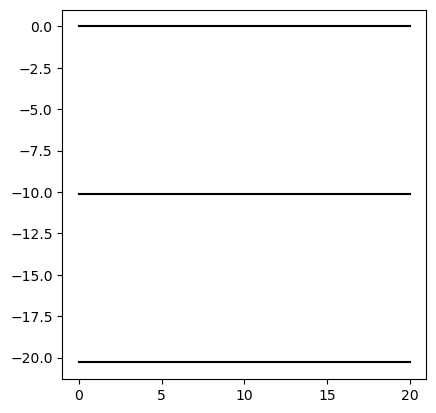

In [12]:
# 绘图，模拟生成一段90度圆弧 + 直线 + 90度圆弧
# 两条线之间间隔 10.15
line_1 = LineString(((0, 0), (20, 0)))
line_2 = LineString(((0, -10.15), (20, -10.15)))
line_3 = LineString(((0, -20.3), (20, -20.3)))
_, ax = plt.subplots()
ax.plot(*line_1.xy, color='black')
ax.plot(*line_2.xy, color='black')
ax.plot(*line_3.xy, color='black')
ax.set_aspect('equal')

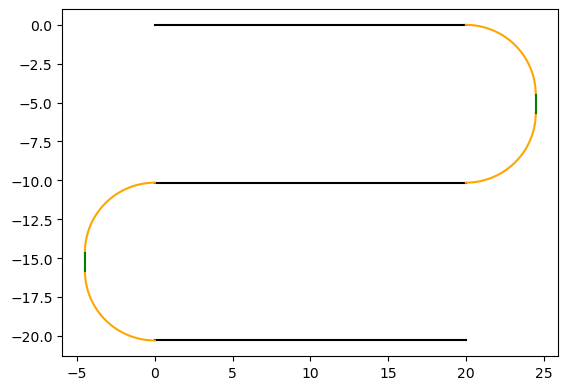

In [13]:
from math import pi
# 在 “右侧” 制作线，如果是放到 gen_path_tillage_method 中则是 “上侧”
curve_1 = CPP_Planner_TurningRail_Maker.gen_single_curve(
    (line_1.coords[-1][0], line_1.coords[-1][1] - turning_radius), turning_radius, 0.1, 0, pi / 2)
padding_1 = LineString(
    ((line_1.coords[-1][0] + turning_radius, line_1.coords[-1][1] - turning_radius)
    , (line_1.coords[-1][0] + turning_radius, line_2.coords[-1][1] + turning_radius))
)
curve_2 = CPP_Planner_TurningRail_Maker.gen_single_curve(
    (line_2.coords[-1][0], line_2.coords[-1][1] + turning_radius), turning_radius, 0.1,
    -pi / 2, 0
)

curve_3 = CPP_Planner_TurningRail_Maker.gen_single_curve(
    (line_2.coords[0][0], line_2.coords[0][1] - turning_radius), turning_radius, 0.1,
    pi/2, pi
)
padding_2 = LineString(
    ((line_2.coords[0][0] - turning_radius, line_2.coords[0][1] - turning_radius),
     (line_2.coords[0][0] - turning_radius, line_3.coords[0][1] + turning_radius))
)
curve_4 = CPP_Planner_TurningRail_Maker.gen_single_curve(
    (line_2.coords[0][0], line_3.coords[0][1] + turning_radius), turning_radius, 0.1,
    pi, pi * 3 / 2
)
_, ax = plt.subplots()
ax.plot(*line_1.xy, color='black')
ax.plot(*line_2.xy, color='black')
ax.plot(*line_3.xy, color='black')
ax.plot(*curve_1.xy, color='orange')
ax.plot(*curve_2.xy, color='orange')
ax.plot(*curve_3.xy, color='orange')
ax.plot(*curve_4.xy, color='orange')
ax.plot(*padding_1.xy, color='green')
ax.plot(*padding_2.xy, color='green')
ax.set_aspect('equal')

In [14]:
line_1.coords[-1][0] + turning_radius

24.5

In [15]:
# turning_paths = CPP_Planner_TurningRail_Maker.gen_path_flat_turn_tail_turn(path, turning_radius, vehicle_length, vehicle_width, swath_width)
# print(turning_paths)

In [16]:
# _, ax = plt.subplots()
# path.plot(ax=ax, color='y')
# for line in turning_paths:
#     line.plot(ax=ax, color='b')

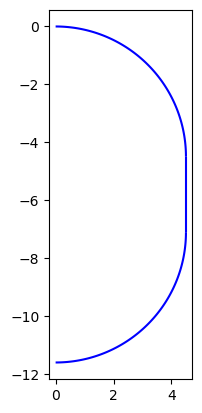

In [17]:
# 测试生成一个 弓 形的路径，标准路径，路径的上侧圆弧起点标准化到 （0， 0），分为左向和右向
bow1 = CPP_Planner_TurningRail_Maker.gen_bow_shape_curve(turning_radius, 7, 1.45, 'right', 1)
_, ax = plt.subplots()
bow1.plot(ax=ax, color='b')
ax.set_aspect('equal')

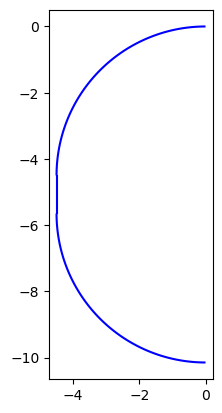

In [18]:
bow2 = CPP_Planner_TurningRail_Maker.gen_bow_shape_curve(turning_radius, 7, 1.45, 'left', 0)
_, ax = plt.subplots()
bow2.plot(ax=ax, color='b')
ax.set_aspect('equal')

In [19]:
list(path.geometry)

[<LINESTRING (440465.118 4397470.121, 440422.035 4397470.121, 440383.425 4397...>,
 <LINESTRING (440464.286 4397471.558, 440422.485 4397471.558, 440383.131 4397...>,
 <LINESTRING (440463.454 4397472.995, 440308.175 4397472.995)>,
 <LINESTRING (440462.622 4397474.432, 440308.254 4397474.432)>,
 <LINESTRING (440461.79 4397475.869, 440308.637 4397475.869)>,
 <LINESTRING (440460.958 4397477.307, 440309.26 4397477.307)>,
 <LINESTRING (440460.126 4397478.744, 440309.884 4397478.744)>,
 <LINESTRING (440459.294 4397480.181, 440310.507 4397480.181)>,
 <LINESTRING (440458.462 4397481.618, 440311.131 4397481.618)>,
 <LINESTRING (440457.63 4397483.055, 440311.754 4397483.055)>,
 <LINESTRING (440456.474 4397484.493, 440313.59 4397484.493)>,
 <LINESTRING (440455.189 4397485.93, 440319.986 4397485.93)>,
 <LINESTRING (440332.294 4397487.367, 440447.435 4397487.367)>]

### 生成 “鱼尾” 转向

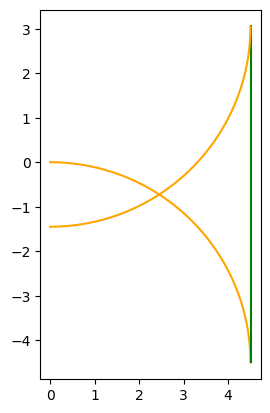

In [20]:
# 假设 仍然标准化到 原点
curve_1 = CPP_Planner_TurningRail_Maker.gen_single_curve((0, -turning_radius), turning_radius, 0.1, 0, pi / 2)
padding_1 = LineString((
    (turning_radius, -turning_radius), (turning_radius, -swath_width + turning_radius)
))
curve_2 = CPP_Planner_TurningRail_Maker.gen_single_curve((0, turning_radius - swath_width), turning_radius,0.1 , -pi / 2, 0)
_, ax = plt.subplots()
ax.plot(*curve_1.xy, 'orange')
ax.plot(*padding_1.xy, 'g')
ax.plot(*curve_2.xy, 'orange')
ax.set_aspect('equal')

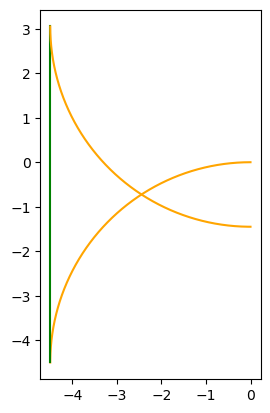

In [21]:
# 反向 鱼尾 （左侧）
curve_1 = CPP_Planner_TurningRail_Maker.gen_single_curve((0, -turning_radius), turning_radius, 0.1, pi/2, pi)
padding_2 = LineString((
    (-turning_radius, -turning_radius), (-turning_radius, -swath_width + turning_radius)
))
curve_2 = CPP_Planner_TurningRail_Maker.gen_single_curve((0, -swath_width + turning_radius), turning_radius, 0.1, pi, pi * 3/2)
_, ax = plt.subplots()
ax.plot(*curve_1.xy, 'orange')
ax.plot(*padding_2.xy, 'g')
ax.plot(*curve_2.xy, 'orange')
ax.set_aspect('equal')

<Axes: >

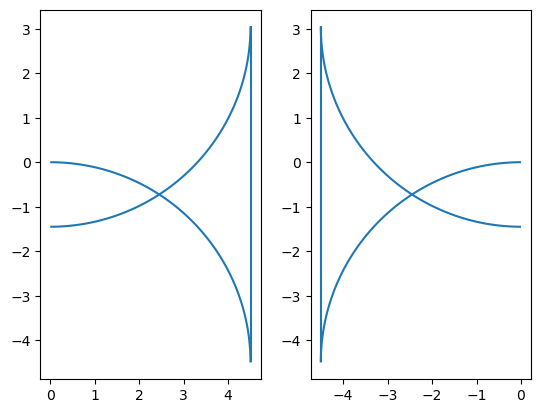

In [22]:
# 测试：
fishtail_1 = CPP_Planner_TurningRail_Maker.gen_fishtail_shape_curve(turning_radius, swath_width, 'right')
fishtail_2 = CPP_Planner_TurningRail_Maker.gen_fishtail_shape_curve(turning_radius, swath_width, 'left')
ax = plt.subplot(121)
fishtail_1.plot(ax=ax)
ax = plt.subplot(122)
fishtail_2.plot(ax=ax)

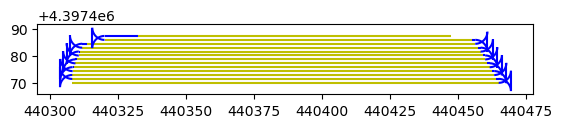

In [23]:
# 测试左右交替生成fishtail
line_1 = LineString(((0, 0), (20, 0)))
line_2 = LineString(((0, -1.45), (20, -1.45)))
line_3 = LineString(((0, -2.9), (20, -2.9)))
# line_gdf = gpd.GeoDataFrame(geometry=[line_3, line_2, line_1])
line_gdf = path
fishtail_1 = CPP_Planner_TurningRail_Maker.gen_fishtail_shape_curve(turning_radius, swath_width, 'right')
fishtail_2 = CPP_Planner_TurningRail_Maker.gen_fishtail_shape_curve(turning_radius, swath_width, 'left')
direction = False  # true right, false left
fishtails = []
for i in range(len(line_gdf) - 1):
    line = line_gdf.geometry.iloc[i]
    line_2 = line_gdf.geometry.iloc[i + 1]
    direction ^= True
    if direction:
        right_point = line.coords[0] if line.coords[0][0] > line.coords[-1][0] else line.coords[-1]
        right_point_2 = line_2.coords[0] if line_2.coords[0][0] > line_2.coords[-1][0] else line_2.coords[-1]
        # 因为 path 是从上到下扫描的，所以这里要留意坐标的位置，加一个 swath_width

        if right_point[0] > right_point_2[0]:
            gap = right_point[0] - right_point_2[0]
            compensate_line = LineString((right_point_2, (right_point_2[0] + gap, right_point_2[1])))
            temp_fishtails = fishtail_1.translate(xoff=right_point[0], yoff=right_point[1] + swath_width)
            pass
        else:  # right_point[0] < right_point_2[0]
            gap = right_point_2[0] - right_point[0]
            compensate_line = LineString((right_point, (right_point[0] + gap, right_point_2[1])))
            temp_fishtails = fishtail_1.translate(xoff=right_point_2[0], yoff=right_point[1] + swath_width)
            pass
        # temp_fishtails = fishtail_1.translate(xoff=right_point[0], yoff=right_point[1] + swath_width)
        fishtails.append(temp_fishtails)
        fishtails.append(gpd.GeoDataFrame(geometry=[compensate_line]))
        pass
    else:  # direction == False
        left_point = line.coords[0] if line.coords[0][0] < line.coords[-1][0] else line.coords[-1]
        left_point_2 = line_2.coords[0] if line_2.coords[0][0] < line_2.coords[-1][0] else line_2.coords[-1]
        if left_point[0] < left_point_2[0]:
            gap = left_point_2[0] - left_point[0]
            compensate_line = LineString(((left_point[0], left_point_2[1]), (left_point_2[0], left_point_2[1])))
            temp_fishtails = fishtail_2.translate(xoff=left_point[0], yoff=left_point[1] + swath_width)
        else:  # left_point[0] > left_point_2[0]
            gap = left_point[0] - left_point_2[0]
            compensate_line = LineString(((left_point_2[0], left_point[1]), (left_point[0], left_point[1])))
            temp_fishtails = fishtail_2.translate(xoff=left_point[0], yoff=left_point[1] + swath_width)

        fishtails.append(temp_fishtails)
        fishtails.append(gpd.GeoDataFrame(geometry=[compensate_line]))

        # temp_fishtails = fishtail_2.translate(xoff=left_point[0], yoff=left_point[1] + swath_width)
        # fishtails.append(temp_fishtails)
        pass

_, ax = plt.subplots()
line_gdf.plot(ax=ax, color='y')
for fishtail in fishtails:
    fishtail.plot(ax=ax, color='b')

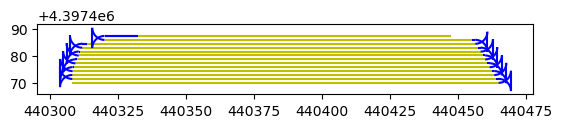

In [24]:
result = CPP_Planner_TurningRail_Maker.gen_fishtail_in_paths(path, turning_radius, swath_width, 6.3, 1.9)
_, ax = plt.subplots()
line_gdf.plot(ax=ax, color='y')
for line in result:
    line.plot(ax=ax, color='b')
# result.plot(ax=ax, color='b')

add one path to fishtail
add one path to fishtail
add one path to fishtail
making fishtails, total: 3 paths
making fishtails, total: 3 paths
making fishtails, total: 3 paths
making fishtails, total: 3 paths
making fishtails, total: 3 paths
<class 'geopandas.geodataframe.GeoDataFrame'>
<class 'geopandas.geodataframe.GeoDataFrame'>
<class 'geopandas.geodataframe.GeoDataFrame'>
<class 'geopandas.geodataframe.GeoDataFrame'>
<class 'geopandas.geodataframe.GeoDataFrame'>
<class 'geopandas.geodataframe.GeoDataFrame'>
<class 'geopandas.geodataframe.GeoDataFrame'>
<class 'geopandas.geodataframe.GeoDataFrame'>
<class 'geopandas.geodataframe.GeoDataFrame'>
<class 'geopandas.geodataframe.GeoDataFrame'>
<class 'geopandas.geodataframe.GeoDataFrame'>
<class 'geopandas.geodataframe.GeoDataFrame'>
<class 'geopandas.geodataframe.GeoDataFrame'>
<class 'geopandas.geodataframe.GeoDataFrame'>
<class 'geopandas.geodataframe.GeoDataFrame'>


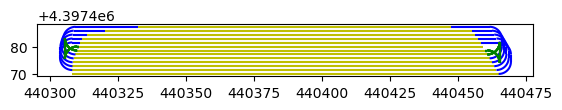

In [25]:
flat_turn, fishtail_turn = CPP_Planner_TurningRail_Maker.gen_path_flat_turn_tail_turn(path, turning_radius, vehicle_length, vehicle_width, swath_width)
_, ax = plt.subplots()
path.plot(ax=ax, color='y')
for line in flat_turn:
    line.plot(ax=ax, color='b')
for line in fishtail_turn:
    print(type(line))
    line.plot(ax=ax, color='g')

## 要添加 centroid 和 theta，上面的不一定能跑了